# MultiCollinearity Elimination class
This Jupter notebook is used to build and test a general class for multicollinearity elimination. The latter is based on Particle Swarm Optimization algorithm.

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Helper functions

In [43]:
def display_df_heat_map(data: pd.DataFrame, title: str, mask=None, column_names: list=None, row_names:list=None):
    if column_names is not None:
        data = data.rename(columns=column_names)

    if row_names is not None:
        data = data.rename(index=row_names)


    plt.figure(figsize=(15,15))
    sns.heatmap(data, linewidth = 1 , annot = True, mask=mask)
    plt.title(title)
    plt.show()


In [44]:
def _create_mask(n: int, title: str):
    # the title should correspond to the size of the consecutive clusters
    values = [int(v) for v in title.split("-") if len(v) > 0]
    mask = np.full(shape=(n, n), fill_value=True)
    counter=0

    for v in values:
        for i in range(n - 1 - counter, n - 1 - counter - v, -1):
            for j in range(counter, counter + v):
                mask[i][j] = False
        counter += v
    return mask

    

## PsoMultiCol class
this class is the one responsible for eliminating multi-correlation using Particle Swarm Optimization

In [45]:
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sko.PSO import PSO
from math import floor
from sklearn.decomposition import PCA


class PsoMultiCol:
    def set_data(self, df, display=True):
        self.df = df
        # calculate the spearmanr correlation of the dataframe's features
        corr = spearmanr(df).correlation
        # make sure it is symmetric
        corr = (corr + corr.T) / 2
        # fill the diagonal with 1s
        np.fill_diagonal(corr, 1)
        # transform the matrix to a dataframe that represents how similar each feature it is to another
        self.dis_matrix = pd.DataFrame(data= (1 - np.abs (corr)), columns=list(df.columns), index=list(df.columns))
        # have a dictionary mapping the column's order to its name
        self.columns_dict = dict(list(zip(range(len(df.columns)), df.columns)))
        # set the number of features for later reference
        self.num_feats = len(df.columns)
        # save the column names for later reference
        self.columns = list(df.columns)
       
        if display:
            display_df_heat_map(self.dis_matrix, "Initial correlation matrix", column_names=self.columns_dict, row_names=self.columns_dict)
       
       
    def __init__ (self, df:pd.DataFrame=None, max_iter:int= 200, vif_threshold:float=2.5,
                  min_fraction=0.40, max_fraction=0.76, step=0.05):
        # maximum number of iterations in the PSO algorithm
        self.max_iter = max_iter
        self.pso = None
        # the value that determine whether columns are multicollinear or not
        self.vif_threshold = vif_threshold

        # parameters to determine the range of values for the maximum number of iterations
        self.min_fraction = min_fraction
        self.max_fraction = max_fraction
        self.step = step

        if df is not None:
            self.set_data(df)

    
    def _get_vif(self, df=None):
        if df is None:
            df = self.df
        
        vif = pd.DataFrame()
        vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
        vif['variables'] = df.columns
        return vif.set_index('variables')   
    
    
    def _get_clusters(self, particle: np.array):
        particle_size = len(particle)
        discrete_particle = np.array([int(x) for x in particle])
        cluster_feats = {}
        for i in range(particle_size) :
            # if the value of the cluster is not in the dictinary, initialize the list
            if discrete_particle[i] not in cluster_feats:
                cluster_feats[discrete_particle[i]] = []
            # the cluster_feats will be a map between numbers representing clusters
            # and the columns belonging to that cluster
            cluster_feats[discrete_particle[i]].append(i)
        
        return cluster_feats    
    
    def _cluster_scores(self, cluster_feats: dict):
        cluster_names = {}
        new_order = []
        title = ""
        
        # map each cluster to its column names
        for c, feats in cluster_feats.items():
            cluster_names[c] = [self.columns_dict[i] for i in feats]
            new_order.extend(feats)
            title += f"{len(feats)}-"
                        
        inner_cluster_score = 0
        for c, num_columns in cluster_feats.items():
            inner_cluster_score += ( 1 + np.exp((np.sqrt(self.dis_matrix.iloc[num_columns, num_columns]).values).sum())) / (np.log(len(num_columns)) + np.exp(1))
        return inner_cluster_score 

    def _pso_function(self, particle: np.array):         
        return self._cluster_scores(self._get_clusters(particle))
        
    
    def _cluster_pso(self, num_clusters, display=True):
        # determine the function object to pass to the PSO algorithm
        pso_function = lambda x: self._pso_function(x)
        # bounds
        lower_bound = np.zeros(self.num_feats)
        upper_bound = np.full(shape=self.num_feats, fill_value = num_clusters, dtype="float")
        
        pso =  PSO(func=pso_function, n_dim = self.num_feats, pop=15, max_iter=self.max_iter ,lb=lower_bound, ub=upper_bound, c1=1.5, c2=1.5)
        pso.run()
        
        x, y = pso.gbest_x, pso.gbest_y
        
        cluster_feats = self._get_clusters(x)
        
        new_order = [] 
        title = ""
        for _, f in cluster_feats.items():
            new_order.extend(f)
            title += f'{len(f)}-'
        
        if display:
            print(f"The best score achieved by the PSO algorithm with a maximum of {num_clusters} clusters is: {y}")      
            new_dist_matrix = self.dis_matrix.iloc[new_order[::-1], new_order]
            mask = _create_mask(self.num_feats, title)
            display_df_heat_map(new_dist_matrix, f"features grouped with a maximum of {num_clusters} clusters", column_names=self.columns_dict, row_names=self.columns_dict, mask=mask)
        
        return x, y
    
    def _find_best_cluster(self, display=True, display_best=True):
        best_score = np.inf
        best_x = None   
        last_num_clusters = 0
        for fraction in np.arange(self.min_fraction, self.max_fraction, self.step):            
            num_clusters = max(floor(fraction  * self.num_feats), 3)

            if num_clusters == last_num_clusters: 
                continue
            
            last_num_clusters = num_clusters
            
            x, y = self._cluster_pso(num_clusters, display=display)
            if y < best_score:
                best_score = y
                best_x = x
        
        cluster_feats = self._get_clusters(best_x)
        
        new_order = [] 
        title = ""
        for _, f in cluster_feats.items():
            new_order.extend(f)
            title += f'{len(f)}-'
        
        if display_best:
            print(f"best scored achieved by the PSO algorithm: {best_score}")            
            new_dist_matrix = self.dis_matrix.iloc[new_order[::-1], new_order]
            mask = _create_mask(self.num_feats, title, )
            display_df_heat_map(new_dist_matrix, f"final feature-grouping", column_names=self.columns_dict, row_names=self.columns_dict, mask=mask)
         
        return best_x
    
    def _get_new_df(self, best_particle):
        # define a PCA object to combine the clustered 
        pca = PCA(n_components=1)

        # get the clusters out of the particle
        clusters = self._get_clusters(best_particle)
        # get the cluster
        new_dfs = []
        
        for _, feats in clusters.items():
            # reduce the clusted features into a single more informative feature
            new_feats = pd.DataFrame(data=pca.fit_transform(self.df.iloc[:, feats]), index=list(self.df.index), columns=[self.columns_dict[feats[0]]])
            new_dfs.append(new_feats)
        
        # return the features concatenated horizontally 
        return pd.concat(new_dfs, axis=1, ignore_index=False)
                        
        
    def eliminate_multicol(self, df: pd.DataFrame, display_first=True, verbose=True, display_best=True):
        if not isinstance(df, pd.DataFrame):
            df = pd.DataFrame(data=df, columns=range(df.shape[1]))
        
        # first of all determine the vifs of the different columns
        vif = self._get_vif(df)
        # retrieve multicollinear variables
        collinear = list(vif[vif['VIF'] >= self.vif_threshold].index)
        collinear_df = df.loc[:, collinear]

        # retrieve the non-collinear part
        non_collinear = [c for c in df.columns if c not in collinear]
        non_collinear_df = df.loc[:, non_collinear]
        
        # if there are no collinear columns, no further preprocessing is needed
        if not collinear:
            return df
        
        # set the df field to the fraction of the dataframe with only multicollinear columns
        self.set_data(collinear_df, display=display_first)
        # retrieve the best particle
        best_x = self._find_best_cluster(display=verbose, display_best=display_best)
        
        # retrieve the new representation of the collinear features
        new_collinear_df = self._get_new_df(best_x)
        # concatenate the two parts to form the final dataframe
        return pd.concat([non_collinear_df, new_collinear_df], axis=1, ignore_index=False).rename(columns=lambda x: str(x))
   

## Test The Multicollinearity Elimination on a generated classfication dataset

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


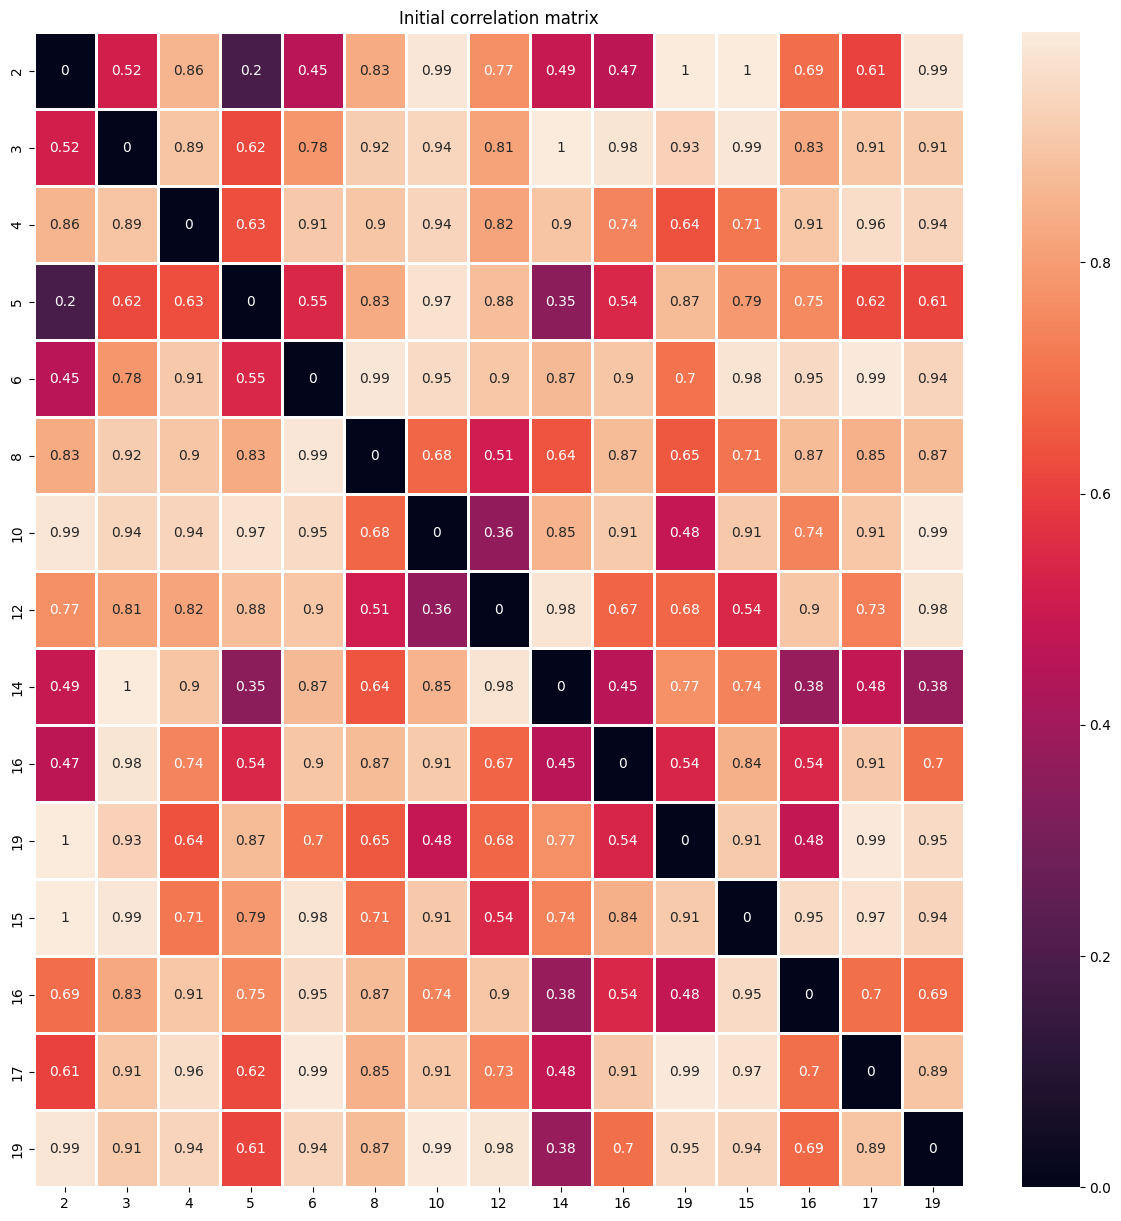

best scored achieved by the PSO algorithm: [10.18836277]


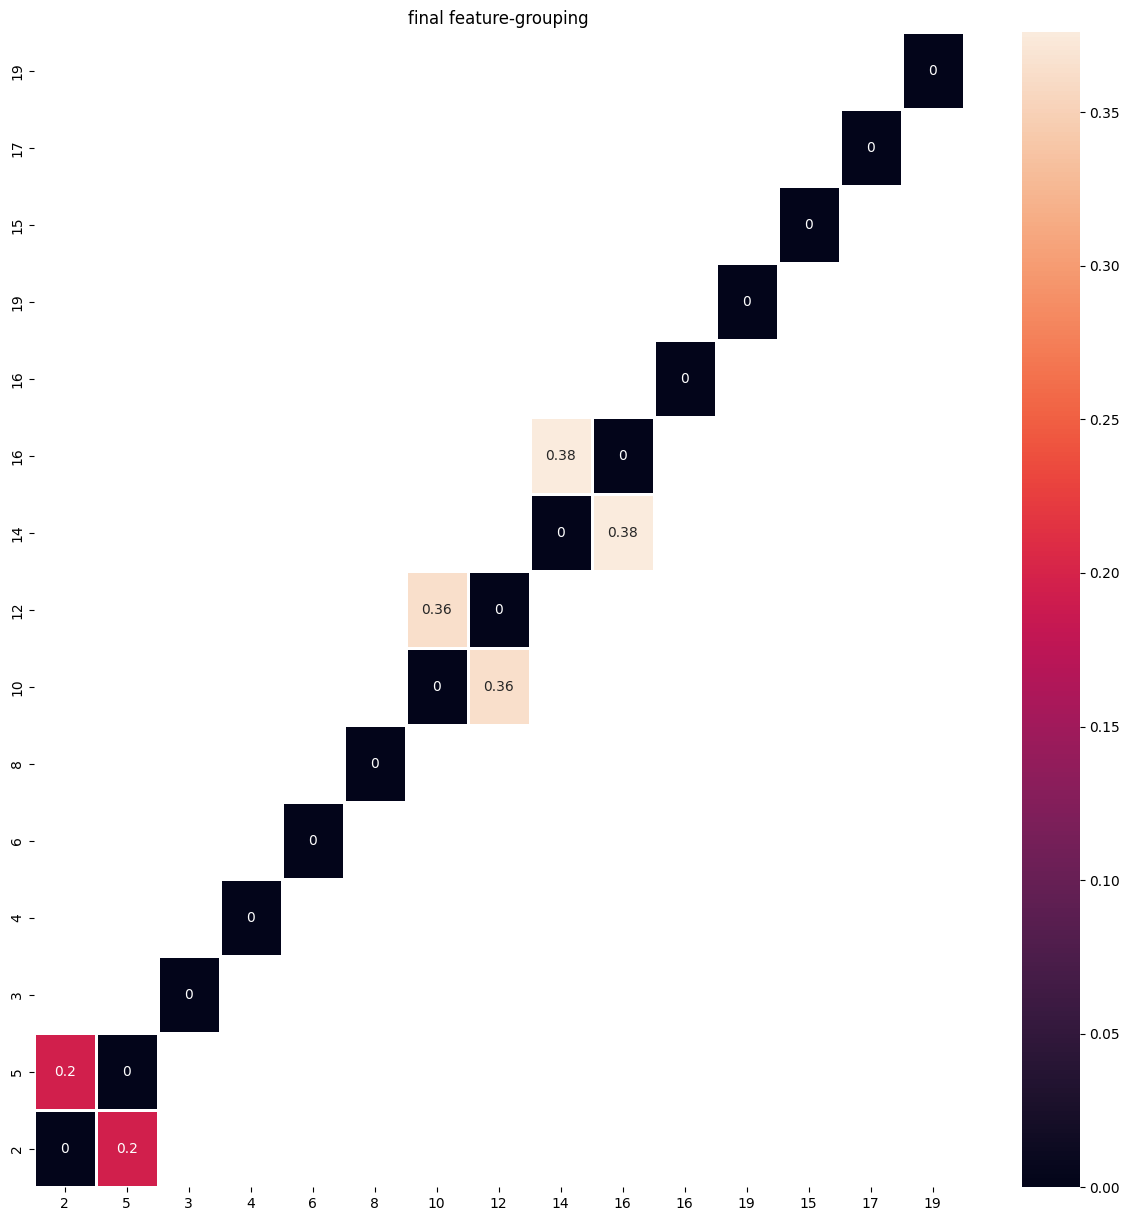

In [46]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


X1, y = make_classification(4000, n_features=20, n_informative=10, n_redundant=5, n_classes=2, shuffle=True, random_state=10)
mce = PsoMultiCol()
X2 = mce.eliminate_multicol(X1, display_first=True, verbose=False, display_best=True)

In [47]:
from classifiers import try_model

# train a number of methods on both datasets
lr_basic = LogisticRegression(max_iter=15000)
lr_grid = {"C": np.logspace(-4, 2.1, 20)}

knn_basic = KNeighborsClassifier()
knn_grid = {'n_neighbors' : list(range(3, 21, 2)),
            'weights' : ['uniform','distance'],
}

dtr_basic = DecisionTreeClassifier(random_state=11)
dtr_grid = {"max_features": np.arange(0.7, 1.01, 0.1), 
            "max_depth": range(10, 21, 2), 
             "min_samples_split":np.arange(0.02, 0.055, 0.01), 
             "min_samples_leaf": range(1, 21, 2)  
}

rfr_basic = RandomForestClassifier(random_state=11)
rfr_grid = {"n_estimators": [100], 
             "max_depth": range(10, 21, 2), 
             "min_samples_split": np.arange(0.02, 0.041, 0.01), 
             "min_samples_leaf": range(1, 7, 2)
}

names = ['Logistic Regression', 'K-Nearest-Neighbors', 'Decision Tree', 'Random Forest']

classifiers = [(lr_basic, lr_grid), (knn_basic, knn_grid), (dtr_basic, dtr_grid), (rfr_basic, rfr_grid)]


In [48]:

for n, c in zip(names, classifiers): 
    results_1 = try_model(c[0], X1, y, c[1], test_metrics=['accuracy', 'f1', 'balanced_accuracy'], save=False)
    print(f"results of {c[0]} with the first dataset: ", results_1, sep='\n')
    print()
    results_2 = try_model(c[0], X2, y, c[1], test_metrics=['accuracy', 'f1', 'balanced_accuracy'], save=False)

    print(f"results of {c[0]} with the first dataset: ", results_2, sep='\n')
    print("\n")


results of LogisticRegression(max_iter=15000) with the first dataset: 
(LogisticRegression(C=0.01767536622987673, max_iter=15000), {'accuracy': 0.83875, 'f1': 0.8473372781065087, 'balanced_accuracy': 0.8386146163413521})

results of LogisticRegression(max_iter=15000) with the first dataset: 
(LogisticRegression(C=0.01767536622987673, max_iter=15000), {'accuracy': 0.84, 'f1': 0.8483412322274881, 'balanced_accuracy': 0.8398677491734323})


results of KNeighborsClassifier() with the first dataset: 
(KNeighborsClassifier(n_neighbors=9), {'accuracy': 0.96375, 'f1': 0.9638854296388543, 'balanced_accuracy': 0.9637466484165526})

results of KNeighborsClassifier() with the first dataset: 
(KNeighborsClassifier(n_neighbors=7), {'accuracy': 0.96375, 'f1': 0.9638854296388543, 'balanced_accuracy': 0.9637466484165526})


results of DecisionTreeClassifier(random_state=11) with the first dataset: 
(DecisionTreeClassifier(max_depth=12, max_features=0.8999999999999999,
                       min_samples

KeyboardInterrupt: 

## Test data with the breast cancer dataset

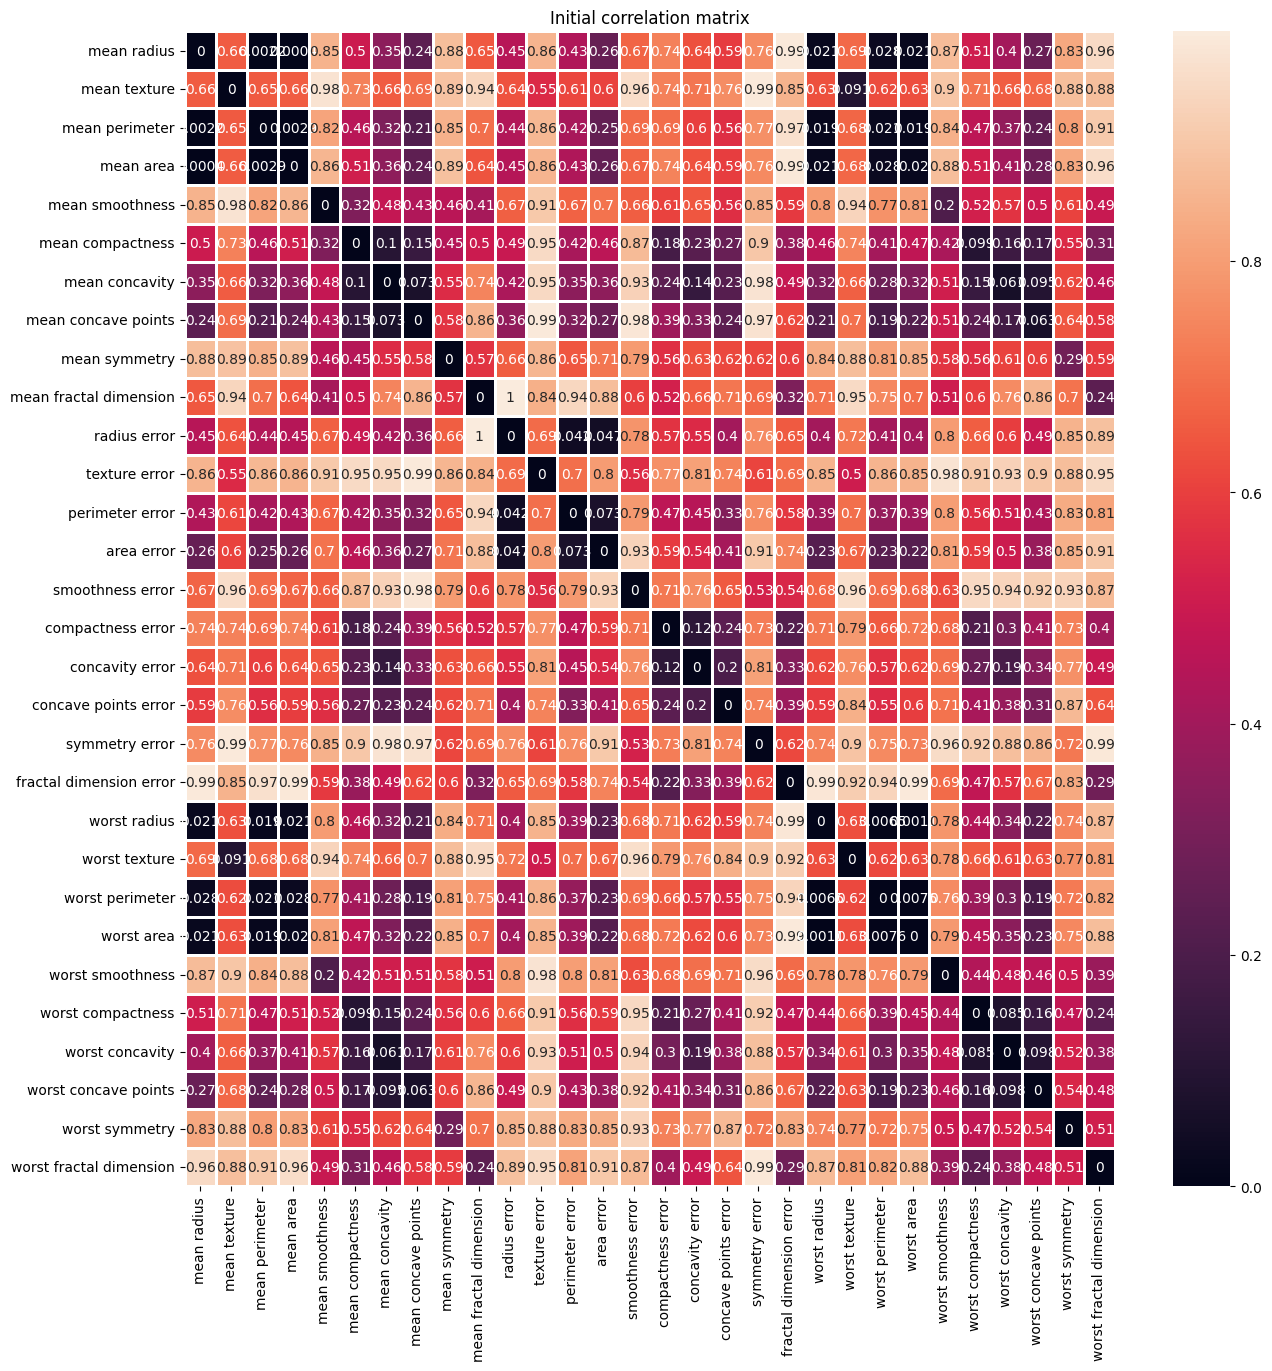

best scored achieved by the PSO algorithm: [19.90672293]


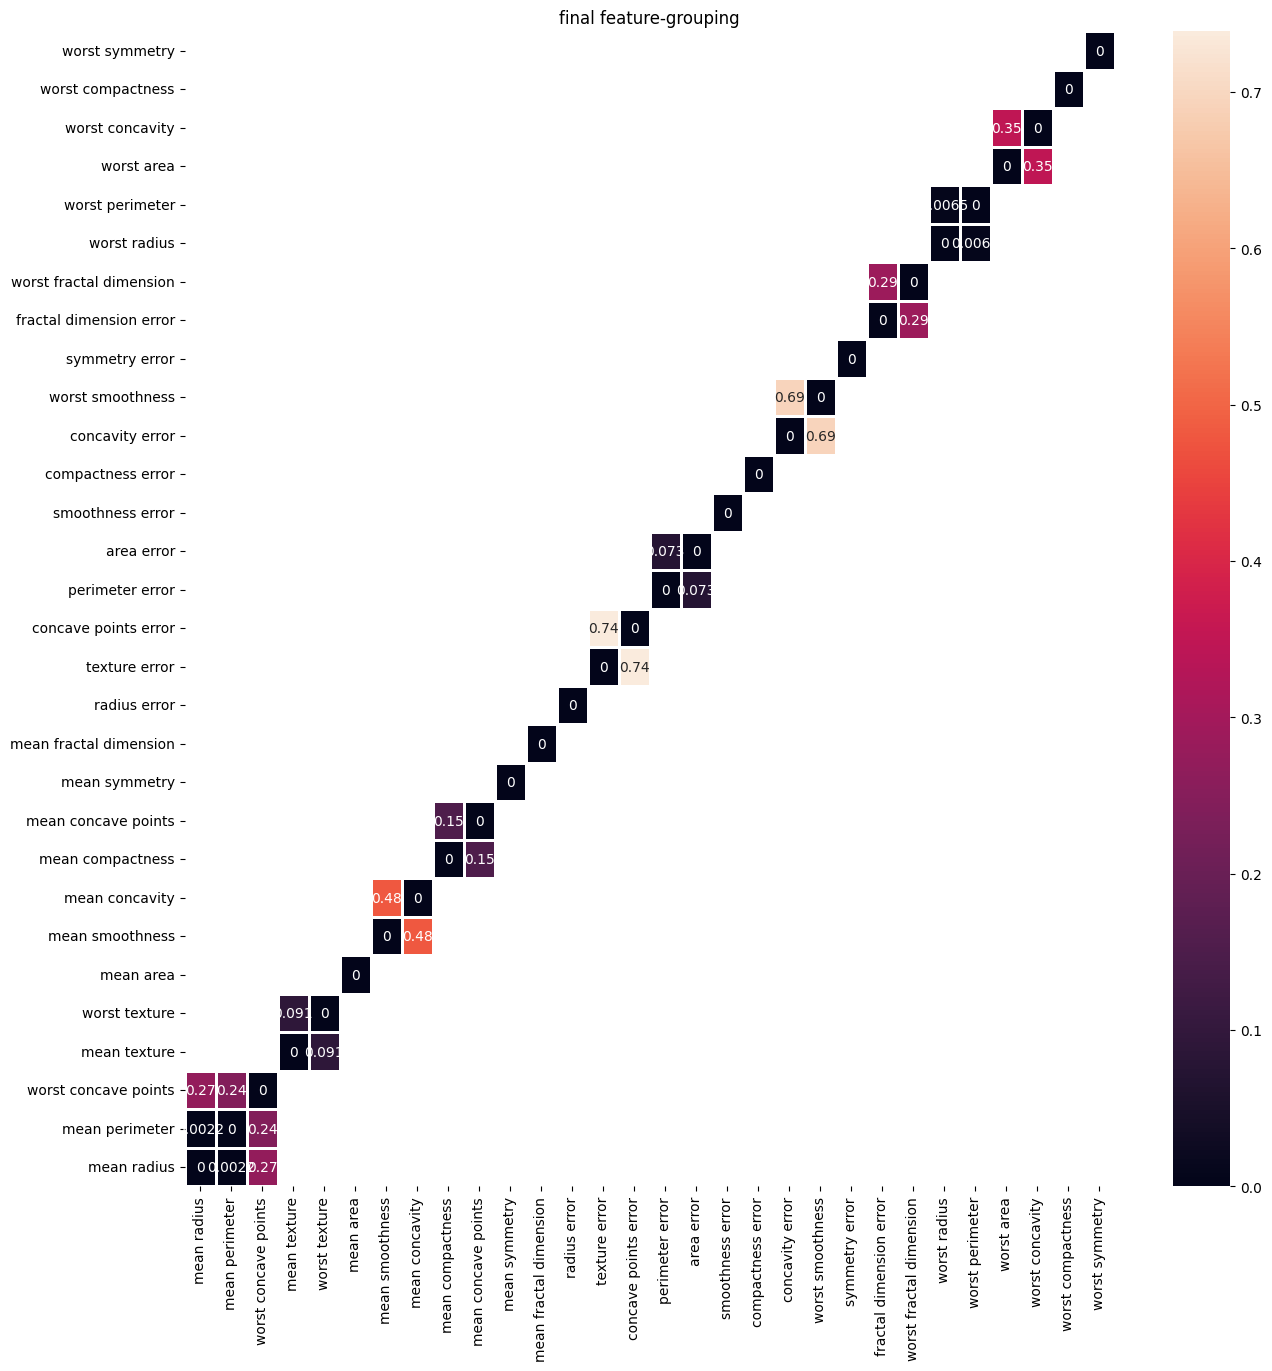

data originally
Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')
data after multicollinearity elimination
Index(['mean radius', 'mean texture', 'mean area', 'mean smoothness',
       'mean compactness', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'smoothness error',
       'compactness error', 'concavity error', 'symmetry error'

In [ ]:
# first load the dataset
from sklearn.datasets import load_breast_cancer
data, target = load_breast_cancer(as_frame=True, return_X_y=True)
mse = PsoMultiCol()
new_data = mse.eliminate_multicol(data, display_first=True, verbose=False, display_best=True)

print("data originally", data.columns, sep="\n")
print("data after multicollinearity elimination", new_data.columns, sep="\n")

In [49]:
for n, c in zip(names, classifiers): 
    results_1 = try_model(c[0], data, target, c[1], test_metrics=['accuracy', 'f1', 'balanced_accuracy'], save=False)
    print(f"results of {c[0]} with the first dataset: ", results_1, sep='\n')
    print()
    results_2 = try_model(c[0], new_data, target, c[1], test_metrics=['accuracy', 'f1', 'balanced_accuracy'], save=False)
    print(f"results of {c[0]} with the second dataset: ", results_2, sep='\n')
    print("\n")


results of LogisticRegression(max_iter=15000) with the first dataset: 
(LogisticRegression(C=28.700848540715675, max_iter=15000), {'accuracy': 0.9298245614035088, 'f1': 0.9459459459459458, 'balanced_accuracy': 0.9146825396825397})

results of LogisticRegression(max_iter=15000) with the second dataset: 
(LogisticRegression(C=125.89254117941675, max_iter=15000), {'accuracy': 0.9385964912280702, 'f1': 0.9523809523809524, 'balanced_accuracy': 0.9265873015873016})


results of KNeighborsClassifier() with the first dataset: 
(KNeighborsClassifier(n_neighbors=15, weights='distance'), {'accuracy': 0.9122807017543859, 'f1': 0.9333333333333333, 'balanced_accuracy': 0.8908730158730158})

results of KNeighborsClassifier() with the second dataset: 
(KNeighborsClassifier(n_neighbors=15, weights='distance'), {'accuracy': 0.9122807017543859, 'f1': 0.9333333333333333, 'balanced_accuracy': 0.8908730158730158})


results of DecisionTreeClassifier(random_state=11) with the first dataset: 
(DecisionTreeCla